In [ ]:
# 完整项目请查看https://github.com/CristinaEx/NeuralNetwork-Numpy
# 实现了图形界面（手写测试和随机测试）
# 注：手写测试使用模型在附带的model文件夹里面，需保证解压在该脚本的同一目录下，model里的模型可以自己训练，但时间可能较长，因为我们的卷积网络训练未作优化。
# 实现了卷积网络
# 优化器支持Nesterov RMSProp SGD
# 激活函数支持sigmoid leaky_relu_x x=任意值
# 实现了集成框架->方便模型的创建与保存
# 网络可以使用MainNet任意拼接，每个网络需实现指定接口

In [1]:
#################### mnist load #########################
# 这个模块为读取mnist测试集

import numpy
import struct
import matplotlib.pyplot as plt

# 训练集文件
train_images_idx3_ubyte_file = 'MNIST_data/train-images.idx3-ubyte'
# 训练集标签文件
train_labels_idx1_ubyte_file = 'MNIST_data/train-labels.idx1-ubyte'
# 测试集文件
test_images_idx3_ubyte_file = 'MNIST_data/t10k-images.idx3-ubyte'
# 测试集标签文件
test_labels_idx1_ubyte_file = 'MNIST_data/t10k-labels.idx1-ubyte'


def decode_idx3_ubyte(idx3_ubyte_file):
    """
    解析idx3文件的通用函数
    :param idx3_ubyte_file: idx3文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx3_ubyte_file, 'rb').read()

    # 解析文件头信息，依次为魔数、图片数量、每张图片高、每张图片宽
    offset = 0
    fmt_header = '>iiii' #因为数据结构中前4行的数据类型都是32位整型，所以采用i格式，但我们需要读取前4行数据，所以需要4个i。我们后面会看到标签集中，只使用2个ii。
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    print('魔数:%d, 图片数量: %d张, 图片大小: %d*%d' % (magic_number, num_images, num_rows, num_cols))

    # 解析数据集
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)  #获得数据在缓存中的指针位置，从前面介绍的数据结构可以看出，读取了前4行之后，指针位置（即偏移位置offset）指向0016。
    print(offset)
    fmt_image = '>' + str(image_size) + 'B'  #图像数据像素值的类型为unsigned char型，对应的format格式为B。这里还有加上图像大小784，是为了读取784个B格式数据，如果没有则只会读取一个值（即一副图像中的一个像素值）
    print(fmt_image,offset,struct.calcsize(fmt_image))
    images = numpy.empty((num_images, num_rows, num_cols))
    #plt.figure()
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print('已解析 %d' % (i + 1) + '张')
            print(offset)
        images[i] = numpy.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        #print(images[i])
        offset += struct.calcsize(fmt_image)
#        plt.imshow(images[i],'gray')
#        plt.pause(0.00001)
#        plt.show()
    #plt.show()

    return images


def decode_idx1_ubyte(idx1_ubyte_file):
    """
    解析idx1文件的通用函数
    :param idx1_ubyte_file: idx1文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx1_ubyte_file, 'rb').read()

    # 解析文件头信息，依次为魔数和标签数
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    print('魔数:%d, 图片数量: %d张' % (magic_number, num_images))

    # 解析数据集
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = numpy.empty(num_images)
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print ('已解析 %d' % (i + 1) + '张')
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels


def load_train_images(idx_ubyte_file=train_images_idx3_ubyte_file):
    """
    TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

    :param idx_ubyte_file: idx文件路径
    :return: n*row*col维np.array对象，n为图片数量
    """
    return decode_idx3_ubyte(idx_ubyte_file)


def load_train_labels(idx_ubyte_file=train_labels_idx1_ubyte_file):
    """
    TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.

    :param idx_ubyte_file: idx文件路径
    :return: n*1维np.array对象，n为图片数量
    """
    return decode_idx1_ubyte(idx_ubyte_file)


def load_test_images(idx_ubyte_file=test_images_idx3_ubyte_file):
    """
    TEST SET IMAGE FILE (t10k-images-idx3-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  10000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

    :param idx_ubyte_file: idx文件路径
    :return: n*row*col维np.array对象，n为图片数量
    """
    return decode_idx3_ubyte(idx_ubyte_file)


def load_test_labels(idx_ubyte_file=test_labels_idx1_ubyte_file):
    """
    TEST SET LABEL FILE (t10k-labels-idx1-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  10000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.

    :param idx_ubyte_file: idx文件路径
    :return: n*1维np.array对象，n为图片数量
    """
    return decode_idx1_ubyte(idx_ubyte_file)


In [2]:
################### conv ##########################
# 这个模块是卷积和反卷积

from math import floor,ceil

def conv2d(data,filter,strides=[1,1],padding='SAME'):
    """
    data:数据[batch_size,h,w,channel]
    filter:卷积算子[h,w,channel_in,channel_out]
    strides:步长[dh,dw]
    padding:'VAILD' or 'SAME'
    """
    batch_size,h,w,channel = data.shape
    fh,fw,channel_in,channel_out = filter.shape
    if padding == 'VAILD':
        result = numpy.zeros((batch_size,floor((h-fh)/strides[0])+1,floor((w-fw)/strides[1])+1,channel_out))
        for b in range(batch_size):
            for m in range(floor((h-fh)/strides[0])+1):
                x = int(m*strides[0])
                for n in range(floor((w-fw)/strides[1])+1):
                    y = int(n*strides[1])
                    for c in range(channel_out):
                        result[b,m,n,c]=sum(sum(sum(data[b,x:x+fh,y:y+fw,:]*filter[:,:,:,c])));
    else:
        data0 = numpy.pad(data,((0,0),(floor(fh/2),floor(fh/2)),(floor(fw/2),floor(fw/2)),(0,0)),'constant')
        result0 = conv2d(data0,filter,strides,padding='VAILD')
        result = result0[:,0:h,0:w,:]
    return result

def deconv2d(loss,filter,strides=[1,1],padding='SAME'):
    """
    反卷积
    计算loss传播
    目前仅支持步长为1
    """
    batch_size,h,w,channel = loss.shape
    fh,fw,channel_in,channel_out = filter.shape
    new_filter = filter.transpose(0,1,3,2) # output_channel转换
    new_filter = numpy.flip(new_filter,0)
    new_filter = numpy.flip(new_filter,1) # 算子上下左右翻转
    if padding == 'VAILD':
        data0 = numpy.pad(loss,((0,0),(fh-1,fh-1),(fw-1,fw-1),(0,0)),'constant')
    else:
        data0 = numpy.pad(loss,((0,0),(floor(fh/2),floor(fh/2)),(floor(fw/2),floor(fw/2)),(0,0)),'constant')
    return conv2d(data0,new_filter,strides,'VAILD')

In [3]:
############################## net #################################
# 这个模块是神经网络（核心）

from os import mkdir
from os.path import isdir,dirname,isfile

class MainNet:
    # 多重网络
    def __init__(self,net):
        """
        net:第一个网络
        """
        self.nets = [net] # 网络
        pass

    def addNet(self,net):
        """
        添加网络，接入当前网络最后一级
        """
        self.nets.append(net)

    def addData(self,data):
        """
        向所有网络添加数据
        """
        for net in self.nets:
            net.addData(data)
            data = net.count()

    def count(self):
        """
        返回最后一层输出
        """
        return self.nets[-1].count()

class BNNet:
    # Batch Normalization
    def __init__(self):
        self.data = None # 输入[batch_size,w,h,mod]
        self.gamma = 1
        self.beta = 0
        self.min_error = 1e-8
        pass

    def addData(self,data):
        """
        添加数据[batch_size,w,h,mod]
        """
        self.data = data
        self.u = None
        self.o = None

    def count(self):
        # self.data = [batch_size,w,h,mod]
        batch_size,w,h,mod = self.data.shape
        self.u = numpy.mean(self.data,axis=0) # shape:[w,h,mod]
        self.o = numpy.var(self.data,axis=0) # shape:[batch_size,w,h,mod]
        self.norm = (self.data-self.u)/self.o
        return self.norm*self.gamma+self.beta

    def backward(self,loss,learning_rate): 
        batch_size,w,h,mod = numpy.shape(self.data)

        X_mu = self.data-self.u
        std_inv = 1/numpy.sqrt(self.o+self.min_error)
        dX_norm = loss*self.gamma
        dvar = numpy.sum(dX_norm*X_mu,axis=0)*(-0.5)*std_inv**3
        dmu = numpy.sum(dX_norm*-std_inv,axis=0)+dvar*numpy.mean(-2*X_mu,axis=0)

        dX = dX_norm*std_inv+dvar*2*X_mu/batch_size+dmu/batch_size
        dgamma = numpy.sum(loss*self.norm,axis=0)
        dbeta = numpy.sum(loss,axis=0)

        return dX,dgamma,dbeta

class RMSProp:
    def __init__(self):
        self.r = [] # 累积平方梯度
        self.ro = 0.5 # 衰减速率
        self.min_error = 0.000001 # 小常数
        self.layout_index = 0 # 从后到前的layout
        # filter <- filter - v
        # filter_loss = v

    def regress(self,loss,data,conv_filter,conv_bias,strides,padding,learning_rate):
        """
        进行梯度下降
        loss:经过激活函数传递上来的损失值
        data:上一层参数
        conv_filter:算子
        conv_bias:偏置项
        st_func(conv2d(data,filter)) = now_layout
        strides:[dy,dx]步长
        learning_rate:学习率
        返回filter_loss,bias_loss
        """
        fh,fw,channel_in,channel_out = conv_filter.shape # 当前filter
        [batch_size,m,n,channel_out] = loss.shape

        if len(self.r) <= self.layout_index:
            # 添加初始累积平方梯度
            self.r.append(numpy.zeros([fh,fw,channel_in,channel_out]))
        # [fh,fw,channel_in] .* [fh,fw,channel_in,channel_out] = [1,1,channel_out] 
        # [fh,fw,channel_in,cho] = [fh,fw,channel_in] * [1,1,cho] .* learning_rate / filter_size
        filter_loss = numpy.zeros(conv_filter.shape)
        bias_loss = numpy.zeros(conv_bias.shape)
        [lb,lh,lw,lc] = loss.shape
        K = learning_rate/batch_size
        for b in range(batch_size):
            for x in range(lh):
                x = x*strides[0]
                for y in range(lw):
                    y = y*strides[1]
                    for ch in range(channel_out):
                        filter_loss[:,:,:,ch] = filter_loss[:,:,:,ch] + loss[b,x,y,ch] * data[b,x:x+fh,y:y+fw,:]*K
                        bias_loss[ch] = loss[b,x,y,ch]*K
        # 更新累积梯度
        self.r[self.layout_index] = self.r[self.layout_index] * self.ro + (1-self.ro)*filter_loss*filter_loss;    
        loss = deconv2d(loss,conv_filter,strides,padding) # 更新loss           
        filter_loss = filter_loss/numpy.sqrt(self.r[self.layout_index]+self.min_error)
        self.layout_index = self.layout_index + 1 # 下一层
        return filter_loss,bias_loss,loss

    def __str__(self):
        return 'RMSPROP'

    def reinit(self):
        """
        每次优化时初始化
        """
        self.layout_index = 0

class Nesterov:
    def __init__(self):
        self.v = [] # 初始速度 为0
        self.alpha = 0.5 # 动量参数 v<-alpha*v+Loss
        self.layout_index = 0 # 从后到前的layout
        # filter <- filter - v
        # filter_loss = v

    def regress(self,loss,data,conv_filter,conv_bias,strides,padding,learning_rate):
        """
        进行梯度下降
        loss:经过激活函数传递上来的损失值
        data:上一层参数
        conv_filter:算子
        conv_bias:偏置项
        st_func(conv2d(data,filter)) = now_layout
        strides:[dy,dx]步长
        learning_rate:学习率
        返回filter_loss,bias_loss
        """
        fh,fw,channel_in,channel_out = conv_filter.shape # 当前filter
        [batch_size,m,n,channel_out] = loss.shape

        if len(self.v) <= self.layout_index:
            # 添加初始动量
            self.v.append(numpy.zeros([fh,fw,channel_in,channel_out]))
        conv_filter_new = conv_filter - self.alpha * self.v[self.layout_index]
        loss_new = deconv2d(loss,conv_filter_new,strides,padding) # 针对data的loss
        data_new = data - loss_new
        # [fh,fw,channel_in] .* [fh,fw,channel_in,channel_out] = [1,1,channel_out] 
        # [fh,fw,channel_in,cho] = [fh,fw,channel_in] * [1,1,cho] .* learning_rate / filter_size
        filter_loss = numpy.zeros(conv_filter.shape)
        bias_loss = numpy.zeros(conv_bias.shape)
        [lb,lh,lw,lc] = loss.shape
        K = learning_rate/batch_size
        for b in range(batch_size):
            for x in range(lh):
                x = x*strides[0]
                for y in range(lw):
                    y = y*strides[1]
                    for ch in range(channel_out):
                        filter_loss[:,:,:,ch] = filter_loss[:,:,:,ch] + loss[b,x,y,ch] * data_new[b,x:x+fh,y:y+fw,:]*K
                        bias_loss[ch] = loss[b,x,y,ch]*K
        self.v[self.layout_index] = self.v[self.layout_index]*self.alpha+filter_loss               
        filter_loss = self.v[self.layout_index]
        self.layout_index = self.layout_index + 1 # 下一层
        return filter_loss,bias_loss,loss_new

    def __str__(self):
        return 'NESTEROV'

    def reinit(self):
        """
        每次优化时初始化
        """
        self.layout_index = 0
        

class SGD:
    def __init__(self):
        self.SGD_K = 0.1 # 随机抽取其中的0.1倍进行回归

    def regress(self,loss,data,conv_filter,conv_bias,strides,padding,learning_rate):
        """
        进行随机梯度下降
        loss:经过激活函数传递上来的损失值
        data:上一层参数
        conv_filter:算子
        conv_bias:偏置项
        st_func(conv2d(data,filter)) = now_layout
        strides:[dy,dx]步长
        learning_rate:学习率
        padding:补位方式
        返回filter_loss,bias_loss
        """
        fh,fw,channel_in,channel_out = conv_filter.shape # 当前filter
        [batch_size,m,n,channel_out] = loss.shape
        SGD_NUM = ceil(m*n*self.SGD_K) # 每个batch抽取SGD_NUM个区域进行回归,每个区域大小为[fh,fw,channel_in]
        # [fh,fw,channel_in] .* [fh,fw,channel_in,channel_out] = [1,1,channel_out] 
        # [fh,fw,channel_in,cho] = [fh,fw,channel_in] * [1,1,cho] .* learning_rate / filter_size
        filter_loss = numpy.zeros(conv_filter.shape)
        bias_loss = numpy.zeros(conv_bias.shape)
        [lb,lh,lw,lc] = loss.shape
        x0 = numpy.random.randint(lh,size=SGD_NUM)
        y0 = numpy.random.randint(lw,size=SGD_NUM)
        K = learning_rate/SGD_NUM/batch_size
        for b in range(batch_size):
            for j in range(SGD_NUM):
                x = x0[j]*strides[0]
                y = y0[j]*strides[1]
                for ch in range(channel_out):
                    filter_loss[:,:,:,ch] = filter_loss[:,:,:,ch] + loss[b,x,y,ch] * data[b,x:x+fh,y:y+fw,:]*K
                    bias_loss[ch] = loss[b,x,y,ch]*K
        loss = deconv2d(loss,conv_filter,strides,padding) # 更新loss
        return filter_loss,bias_loss,loss

    def __str__(self):
        return 'SGD'

    def reinit(self):
        pass

class ConvNet:
    # 全卷积神经网络
    def __init__(self):
        self.data = None # 输入[batch_size,w,h,mod]
        self.conv_layout = [] # 卷积层
        self.conv_filter = [] # 每层卷积层对应卷积核
        self.conv_bias = [] # 每个卷积核对应偏置项
        self.st_func = [] # 每层网络对应激活函数
        self.padding = [] # 每层网络对应padding方式
        self.strides = [] # 每层网络卷积核对应步长
        self.regress_tool = SGD() # 默认SGD
        

    def addData(self,data):
        """
        添加数据，数据的shape只能改变batch_size
        """
        self.data = data

    def addConvLayout(self,filter_shape,bias=None,strides=[1,1,1,1],init_type='ZERO',padding='SAME',st_func='NONE'):
        """
        使用前self.data必须构建初始值，或者0值填充
        filter_shape:[w,h,input,output]
        bias:None->默认偏置项,True:有偏置,False:无偏置
        strides:步长
        init_type='ZERO' or 'RANDOM' -> 初始置零或高斯分布(推荐RANDOM)
        padding:VAILD or SAME
        st_func:激活函数 NONE(√) SIGMOID(√) RELU LEAKY_RELU_(alpha值) TANH
        """ 
        if bias == None:
            self.conv_bias.append(numpy.array([]))
        if init_type == 'ZERO':
            self.conv_filter.append(numpy.zeros(filter_shape))
            if not bias == None:
                self.conv_bias.append(numpy.zeros(filter_shape[3]))
        else:
            self.conv_filter.append(numpy.random.standard_normal(filter_shape)/(filter_shape[0]*filter_shape[1]))
            if not bias == None:
                self.conv_bias.append(numpy.random.standard_normal(filter_shape[3]))
        # if self.conv_layout:
        #     data = self.conv_layout[-1]
        # else:
        #     data = self.data
        # layout = conv2d(data,self.conv_filter[-1],strides,padding)
        # if not bias == None:
        #     for channel in range(filter_shape[3]):
        #         layout[:,:,:,channel] += self.conv_bias[-1][channel]
        # if st_func == 'SIGMOID':
        #     layout = self.__sigmoid(layout)
        self.st_func.append(st_func)
        self.padding.append(padding)
        self.strides.append(strides)
        self.conv_layout.append(None)

    def __sigmoid(self,x):
        """
        sigmoid
        return y = 1/(1+exp(-x))
        """
        return 1/(1+numpy.exp(-x))

    def __leakyRelu(self,x,alpha):
        """
        leaky relu = (x<0)*alpha+(x>0)*1
        """
        return ((x<0)*alpha+(x>0))*x

    def __sigmoid_loss(self,y):
        """
        y = 1/(1+exp(-x))
        sigmoid 导数
        返回dy/dx
        """
        return y*(1-y)

    def __leakyRelu_loss(self,y,alpha):
        return (y<0)*alpha+(y>=0)

    def load(self,fileName):
        """
        读取
        """
        if not isfile(fileName):
            return False
        self.__init__() # 初始化
        with open(fileName) as f:
            layout_num = int(f.readline())
            for i in range(layout_num):
                filter_size = [int(x) for x in list(f.readline()[1:-2].split(','))]
                b = False
                if len(list(f.readline())) >= 2:
                    b = True
                strides = [int(x) for x in list(f.readline()[1:-2].split(','))]
                padding = f.readline()[0:-1]
                st_func = f.readline()[0:-1]
                self.addConvLayout(filter_size,bias = b,strides = strides,padding = padding,st_func = st_func)
        for i in range(len(self.conv_filter)):
            data = numpy.load(dirname(fileName) + '\\layout_'+str(i)+'.npz')
            self.conv_filter[i]=data['x']
            self.conv_bias[i]=data['y']
        return True

    def save(self,filename):
        """
        保存
        """
        if not isdir(dirname(filename)):
            mkdir(dirname(filename))
        with open(filename,'w+') as f:
            f.write(str(len(self.conv_filter)))
            f.write('\n')
            for i in range(len(self.conv_filter)):
                f.write(str(self.conv_filter[i].shape))
                f.write('\n')
                f.write(str(self.conv_bias[i].shape))
                f.write('\n')
                f.write(str(self.strides[i]))
                f.write('\n')
                f.write(str(self.padding[i]))
                f.write('\n')
                f.write(str(self.st_func[i]))
                f.write('\n')
        for i in range(len(self.conv_filter)):
            numpy.savez(dirname(filename) + '\\layout_'+str(i),x=self.conv_filter[i],y=self.conv_bias[i])
        return True

    def regress(self,learning_rate,label,regress_type='SGD',loss_type='MSE'):
        """
        后向传播
        learing_rate:学习率
        label:最后一层的标准输出
        regress_type:回归类型(SGD:随机梯度下降...)
        loss_type:MSE or CE(交叉熵)
        返回第一层的loss(反向传播到第一层)
        """
        self.count() # 更新权值
        # 更换优化器
        if not str(self.regress_tool) == regress_type:
            # print('CHANGE REGRESS TYPE')
            if regress_type == 'SGD':
                self.regress_tool = SGD()
            elif regress_type == 'NESTEROV':
                self.regress_tool = Nesterov()
            elif regress_type == 'RMSPROP':
                self.regress_tool = RMSProp()
        self.regress_tool.reinit()

        now_layout = self.conv_layout[-1] # 当前layout
        # -------------------------经过损失函数传播loss---------------------------------
        if loss_type == 'CE':
            min_error = 0.000000001
            loss = (-label/(now_layout+min_error)+(1-label)/(1-now_layout+min_error))
        else:
            # MSE
            loss = 2*(now_layout-label) # loss = d_loss/
        # -------------------------------------------------------------------------------
        for i in range(1,len(self.conv_layout)+1):
            now_layout = self.conv_layout[-i] # 当前layout
            if i == len(self.conv_layout):
                last_layout = self.data
            else:
                last_layout = self.conv_layout[-i-1]
            batch_size,h,w,channel = last_layout.shape
            fh,fw,channel_in,channel_out = self.conv_filter[-i].shape # 当前filter
            # true_layout = st_func^(-1)(label)
            # ---------------------经过激活函数传播loss------------------------
            if self.st_func[-i] == 'SIGMOID':
                loss = loss*self.__sigmoid_loss(now_layout)# loss = (d_loss/d_st_func_out_put) * (d_st_func_out_put/d_hidden_output) = d_loss/d_hidden_output
            elif self.st_func[-i][0:10] == 'LEAKY_RELU':
                alpha = float(self.st_func[-i][11:])
                loss = loss*self.__leakyRelu_loss(now_layout,alpha)
            # -----------------------------------------------------------------
            # 注:d_hidden_output/dw = data
            # 进行梯度下降更新权值
            data = last_layout
            if self.padding[-i] == 'SAME':
                data = numpy.pad(data,((0,0),(floor(fh/2),floor(fh/2)),(floor(fw/2),floor(fw/2)),(0,0)),'constant')
            # conv(data,filter[-1],strides,'VAILD') = now_layout
            # filter[-1] = filter[-1]-sum(```在batch_size维度上累加```learning_rate*loss*data[batch_size,x0:x0+fw,y0:y0+fh,:]/filter_size)
            # --------------------------梯度下降------------------------------
            filter_loss,bias_loss,loss = self.regress_tool.regress(loss,data,self.conv_filter[-i],self.conv_bias[-i],self.strides[-i],self.padding[-i],learning_rate)              
            # ------------------------------------------------------------------
            # 更新后的卷积算子权值
            self.conv_filter[-i] = self.conv_filter[-i] - filter_loss
            if not len(self.conv_bias[-i]) == 0:
                self.conv_bias[-i] = self.conv_bias[-i] - bias_loss
        return loss

    def count(self):
        """
        前向传播，得出结果，输出最后一层
        """
        last_layout = self.data
        for i in range(len(self.conv_layout)):
            layout = conv2d(last_layout,self.conv_filter[i],self.strides[i],self.padding[i])
            if not len(self.conv_bias[i]) == 0:
                filter_shape = self.conv_filter[i].shape
                for channel in range(filter_shape[3]):
                    layout[:,:,:,channel] += self.conv_bias[i][channel]
            if self.st_func[i] == 'SIGMOID':
                layout = self.__sigmoid(layout)
            elif self.st_func[i][0:10] == 'LEAKY_RELU':
                alpha = float(self.st_func[i][11:])
                layout = self.__leakyRelu(layout,alpha)
            self.conv_layout[i] = layout
            last_layout = layout
        return last_layout

    def __str__(self):
        """
        返回网络参数
        """
        result = 'input_data:'
        result += str(self.data.shape) + '\n'
        for i in range(len(self.conv_layout)):
            result += 'filter:'
            result += str(self.conv_filter[i].shape) + '      '
            result += 'bias:'
            if not len(self.conv_bias[i]) == 0:
                result += str(self.conv_bias[i].shape) + '      \n'
            else:
                result += 'None' + '      \n'
            result += 'st_func:' + self.st_func[i] + '\n'
            result += ('layout_' + str(i) + ':')
            result += str(self.conv_layout[i].shape) + '      \n'         
        return result

In [4]:
############################### SGD ##############################
class SGD:
    def __init__(self):
        self.SGD_K = 0.1 # 随机抽取其中的0.1倍进行回归

    def regress(self,loss,data,conv_filter,conv_bias,strides,padding,learning_rate):
        """
        进行随机梯度下降
        loss:经过激活函数传递上来的损失值
        data:上一层参数
        conv_filter:算子
        conv_bias:偏置项
        st_func(conv2d(data,filter)) = now_layout
        strides:[dy,dx]步长
        learning_rate:学习率
        padding:补位方式
        返回filter_loss,bias_loss
        """
        fh,fw,channel_in,channel_out = conv_filter.shape # 当前filter
        [batch_size,m,n,channel_out] = loss.shape
        SGD_NUM = ceil(m*n*self.SGD_K) # 每个batch抽取SGD_NUM个区域进行回归,每个区域大小为[fh,fw,channel_in]
        # [fh,fw,channel_in] .* [fh,fw,channel_in,channel_out] = [1,1,channel_out] 
        # [fh,fw,channel_in,cho] = [fh,fw,channel_in] * [1,1,cho] .* learning_rate / filter_size
        filter_loss = numpy.zeros(conv_filter.shape)
        bias_loss = numpy.zeros(conv_bias.shape)
        [lb,lh,lw,lc] = loss.shape
        x0 = numpy.random.randint(lh,size=SGD_NUM)
        y0 = numpy.random.randint(lw,size=SGD_NUM)
        K = learning_rate/SGD_NUM/batch_size
        for b in range(batch_size):
            for j in range(SGD_NUM):
                x = x0[j]*strides[0]
                y = y0[j]*strides[1]
                for ch in range(channel_out):
                    filter_loss[:,:,:,ch] = filter_loss[:,:,:,ch] + loss[b,x,y,ch] * data[b,x:x+fh,y:y+fw,:]*K
                    bias_loss[ch] = loss[b,x,y,ch]*K
        loss = deconv2d(loss,conv_filter,strides,padding) # 更新loss
        return filter_loss,bias_loss,loss

    def __str__(self):
        return 'SGD'

    def reinit(self):
        pass

魔数:2051, 图片数量: 60000张, 图片大小: 28*28
16
>784B 16 784
已解析 10000张
7839232
已解析 20000张
15679232
已解析 30000张
23519232
已解析 40000张
31359232
已解析 50000张
39199232
已解析 60000张
47039232
魔数:2049, 图片数量: 60000张
已解析 10000张
已解析 20000张
已解析 30000张
已解析 40000张
已解析 50000张
已解析 60000张
魔数:2051, 图片数量: 10000张, 图片大小: 28*28
16
>784B 16 784
已解析 10000张
7839232
魔数:2049, 图片数量: 10000张
已解析 10000张


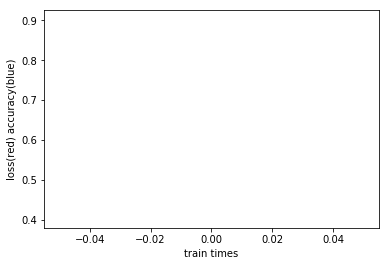

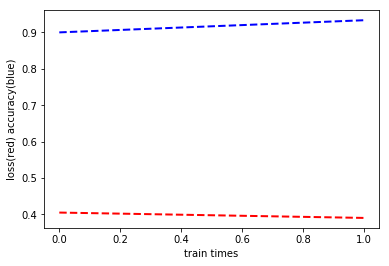

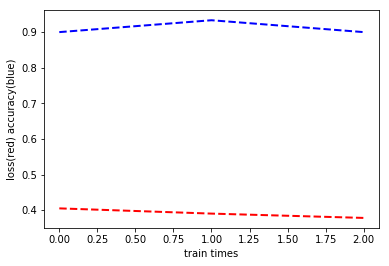

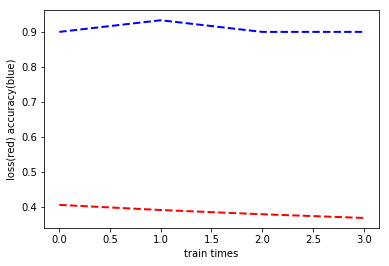

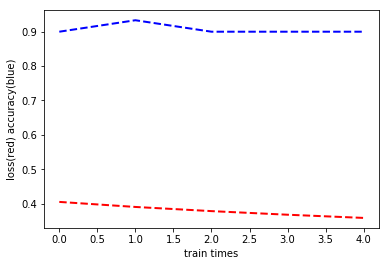

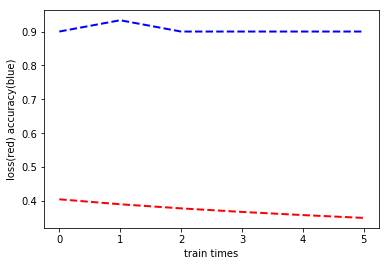

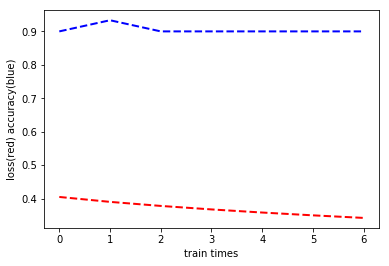

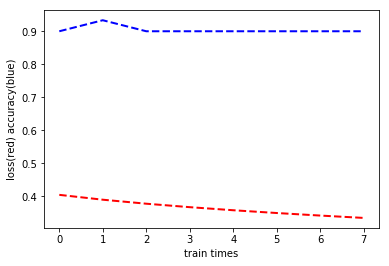

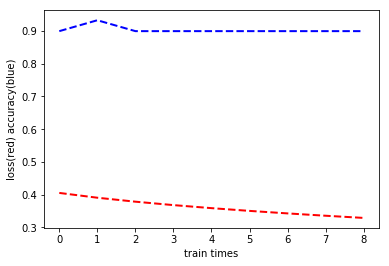

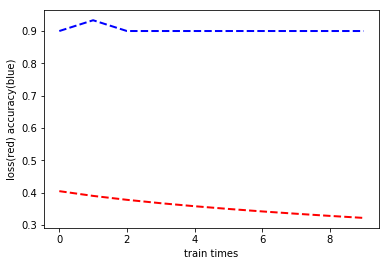

saving...
finish!


In [5]:
############################### train test SGD ###############################
# 运行这个cell测试SGD（注意将最下方train函数的注释去掉）
# 输出loss+accuracy和训练次数的可视化结果(训练的是已训练好的模型，所以accuracy变化可能不大,而且只是一次训练迭代10次，提高train_num可增加训练次数))
# 并将训练模型保存在MODEL_PATH
# 这个cell训练的是已经训练过的模型
# 这个cell训练的模型是在附带的MODEL_PATH里的模型基础上训练的，所以请解压后，保证本脚本与model文件夹在同一目录（也可以自行训练，但训练的时长可能有点长，可以将learning_rate参数提高，train_num参数提高至100以上）

import random
import matplotlib.pyplot as plt # 绘图

MODEL_PATH = 'model\\model.dat'

def num2oneHot(nums,len_):
    """
    nums:列表
    len_:one-hot向量长度
    return one-hot 向量[0:len-1]
    """
    result = []
    for i in range(len(nums)):
        result.append([])
        num = int(nums[i])
        for j in range(num):
            result[i].append(0)
        result[i].append(1)
        for j in range(len_-num-1):
            result[i].append(0)
    return result

def train():
    train_images = load_train_images()
    train_labels = load_train_labels()
    test_images = load_test_images()
    test_labels = load_test_labels()
    
    batch_size = 30
    learning_rate = 0.0001
    train_num = 1 # 训练次数
    it_num = 10 # 每次训练迭代次数
    init_type = 'RANDOM'

    net = ConvNet()
    if not net.load(MODEL_PATH):      
        net.addConvLayout([3,3,1,4],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([3,3,4,8],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([5,5,8,16],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([5,5,16,32],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([16,16,32,64],bias = True,padding='VAILD',st_func='SIGMOID',init_type=init_type)
        net.addConvLayout([1,1,64,10],bias = True,padding='VAILD',st_func='SIGMOID',init_type=init_type)

    for j in range(train_num):
        index = random.randint(1,len(train_images)-batch_size-1)
        # index = 0
        data = train_images[index:index+batch_size]
        data = numpy.reshape(data,[batch_size,28,28,1])
        label = train_labels[index:index+batch_size]
        # 改为one_hot向量
        label = num2oneHot(label,10)
        label = numpy.reshape(label,[batch_size,1,1,10])
        # test_data -> accuracy
        index_test = random.randint(1,len(test_images)-batch_size-1)
        test_data = test_images[index_test:index_test+batch_size]
        test_data = numpy.reshape(test_data,[batch_size,28,28,1])
        test_label = test_labels[index_test:index_test+batch_size]
        # -----------------------------------plt---------------------------------------
        x_data = []
        y_data = []
        t_data = []
        # -----------------------------------------------------------------------------
        for i in range(it_num):
            # accuracy
            net.addData(test_data)
            result = net.count()[:,0,0,:]
            correct_num = 0
            error_num = 0
            for j in range(batch_size):
                m = 0
                for u in range(len(result[j])):
                    if result[j][u] > result[j][m]:
                        m = u
                if int(test_label[j]) == m:
                    correct_num += 1
                else:
                    error_num += 1
            # -----------------------------------plt---------------------------------------
            x_data.append(i)
            t_data.append(correct_num/batch_size)
            plt.plot(x_data,t_data,color='blue',linewidth=2.0,linestyle='--')
            # loss
            net.addData(data)
            loss = sum(sum(sum(sum(abs(net.count()-label)))))/batch_size
            # -----------------------------------plt---------------------------------------
            y_data.append(loss)
            plt.plot(x_data,y_data,color='red',linewidth=2.0,linestyle='--')
            plt.xlabel('train times')
            plt.ylabel('loss(red) accuracy(blue)')
            plt.pause(0.1)
            # -----------------------------------------------------------------------------
            net.regress(learning_rate,label,regress_type='SGD',loss_type = 'CE')  # 进行梯度下降
        print('saving...')
        net.save(MODEL_PATH)
        print('finish!') 
        learning_rate = 0.995*learning_rate
        
    loss = sum(sum(sum(sum(abs(net.count()-label)))))/batch_size
    # print(loss)

    net.save(MODEL_PATH)

# 训练及测试请去除下列函数的注释标号
train()

In [4]:
############################ visual test ##############################
# 这个模块是可视化测试模块，运行前确认在上一个cell的MODEL_PATH保存好模型
# 在这个模块进行手写测试
# 点击RandomTest随机测试测试集内的图像
# 点击右边的clear清除画板，count则是计算画板上手写数字，并在画板下net result中显示结果
# 画板实现了平移不变，但写的字需尽量工整（旋转可能有误差，可以通过增强数据集实现，但这里未做实现）
# 若测试集未成功打开（不在路径），则不能进行随机测试
# 若训练好的模型未保存在MODEL_PATH，则不能进行手写测试和随机测试
import tkinter as tk
from PIL import Image,ImageTk

MODEL_PATH = 'model\\model.dat'

class MnistVisualTest(tk.Frame):
    def __init__(self, master=None):
        super().__init__(master)
        self.master = master
        self.pack()
        self.create_widgets()
        try:
            self.test_images = load_test_images()
            self.test_labels = load_test_labels()
        except:
            pass
        self.net = ConvNet()
        self.net.load(MODEL_PATH)

        self.writeboard_items = []
        

    def create_widgets(self):
        self.fm1=tk.Frame(self)
        self.fm1.grid(column = 0)

        self.txt1 = tk.StringVar()
        self.txt1.set('点击RandomTest进行随机测试')
        self.label1 = tk.Label(self.fm1,textvariable=self.txt1).grid(row=0)
        self.txt2 = tk.StringVar()
        self.txt2.set('当前未进行测试')
        self.label2 = tk.Label(self.fm1,textvariable=self.txt2).grid(row=2)
        self.b_random_test = tk.Button(self.fm1)
        self.b_random_test["text"] = "RandomTest"
        self.b_random_test["command"] = self.randomTest
        self.b_random_test.grid(row = 3)
        self.b_test_all = tk.Button(self.fm1)
        self.b_test_all["text"] = "TestAll(检测速率很慢)"
        self.b_test_all["command"] = self.testAll
        self.b_test_all.grid(row = 4)

        self.fm2=tk.Frame(self)
        self.fm2.grid(column = 1,row = 0)
        self.label2 = tk.Label(self.fm2,text='手写测试').grid(row=0)
        self.writeboard = tk.Canvas(self.fm2, width=200, height=200)
        self.writeboard.grid(row = 1)
        self.writeboard.bind("<B1-Motion>",self.paint)
        self.writeboard_array = numpy.zeros([200,200])

        self.fm3=tk.Frame(self.fm2)
        self.fm3.grid(row=3)
        self.b_clear = tk.Button(self.fm3)
        self.b_clear["text"] = "clear"
        self.b_clear["command"] = self.clear
        self.b_clear.grid(column=0,row = 0)
        self.b_count = tk.Button(self.fm3)
        self.b_count["text"] = "count"
        self.b_count["command"] = self.count
        self.b_count.grid(column=1,row = 0)

        self.txt3 = tk.StringVar()
        self.txt3.set('当前未进行测试')
        self.label3 = tk.Label(self.fm2,textvariable=self.txt3).grid(row=2)

    def count(self):
        data = self.writeboard_array
        # 归一化为mnist形式
        top_y=0
        down_y=len(data)
        number = False
        for i in range(len(data)):
            useful = False
            if number:
                useful = True
            for j in range(len(data[i])):
                if data[i][j] > 100:
                    if number:
                        useful = False
                        break
                    else:
                        number = not number
                        top_y = i
                    break
            if useful:
                down_y = i
                break
        top_x=0
        down_x=len(data[0])
        number = False
        for i in range(len(data[0])):
            useful = False
            if number:
                useful = True
            for j in range(len(data)):
                if data[j][i] > 100:
                    if number:
                        useful = False
                        break
                    else:
                        number = not number
                        top_x = i
                    break
            if useful:
                down_x = i
                break
        data = data[top_y:down_y,top_x:down_x]
        pad_p=0.15
        if down_y-top_y>down_x-top_x:
            pad_y = int((down_y-top_y)*pad_p)
            pad_x = int((down_y-top_y-(down_x-top_x))/2+pad_y)
        else:
            pad_x = int((down_x-top_x)*pad_p)
            pad_y = int((down_x-top_x-(down_y-top_y))/2+pad_x)
        data = numpy.pad(data,((pad_y,pad_y),(pad_x,pad_x)),'constant')
        im = Image.fromarray(data)
        im = im.convert('L')
        im = im.resize((28,28))
        data = numpy.array(im)
        data = numpy.reshape(data,[1,28,28,1])
        self.net.addData(data)
        result = self.net.count()[0,0,0,:]
        j = 0
        for i in range(len(result)):
            if result[i] > result[j]:
                j = i
        self.txt3.set("net result:"+str(j))

    def clear(self):
        self.writeboard_array = numpy.zeros([200,200])
        for item in self.writeboard_items:
            self.writeboard.delete(item)
        self.writeboard_items = []
        self.txt3.set('当前未进行测试')

    def paint(self,event):
        pad = 13
        pad_div=int(pad/2)
        x1,y1 = (event.x - pad_div), (event.y - pad_div)
        x2,y2 = (event.x + pad_div), (event.y + pad_div)
        item = self.writeboard.create_oval(x1, y1, x2, y2, fill="red")
        self.writeboard_items.append(item)
        for i in range(pad):
            for j in range(pad):
                try:
                    self.writeboard_array[event.y-i+pad_div][event.x-j+pad_div] = 255
                except:
                    pass

    def randomTest(self):
        index = random.randint(1,len(self.test_images)-2)
        data = self.test_images[index]
        im = Image.fromarray(data)
        im = im.convert('L')
        # im = im.resize((400,400))
        render= ImageTk.PhotoImage(im)  
        img = tk.Label(self.fm1,image=render)
        img.image = render
        img.grid(row=1)
        # net
        data = numpy.reshape(data,[1,28,28,1])
        label = self.test_labels[index]
        self.txt1.set('label:'+str(int(label)))
        self.net.addData(data)
        result = self.net.count()[0,0,0,:]
        j = 0
        for i in range(len(result)):
            if result[i] > result[j]:
                j = i
        self.txt2.set("net result:"+str(j))

    def testAll(self):
        correct_num = 0
        error_num = 0
        for i in range(len(self.test_images)):
            if i % 1000 == 0:
                self.txt1.set("test"+str(i*1000)+'~'+str((i+1)*1000)+'...')
            data = self.test_images[i]
            data = numpy.reshape(data,[1,28,28,1])
            label = self.test_labels[i]
            self.net.addData(data)
            result = self.net.count()[0,0,0,:]
            j = 0
            for i in range(len(result)):
                if result[i] > result[j]:
                    j = i
            if int(label) == j:
                correct_num += 1
            else:
                error_num += 1
        self.txt1.set("finish!")
        self.txt2.set("correct_rate:"+str(correct_num/(correct_num+error_num)))

if __name__ == '__main__':
    root = tk.Tk()
    # root.geometry("500x500")
    mainview = MnistVisualTest(master=root)
    mainview.mainloop()

魔数:2051, 图片数量: 10000张, 图片大小: 28*28
16
>784B 16 784
已解析 10000张
7839232
魔数:2049, 图片数量: 10000张
已解析 10000张


In [4]:
################################# batch normalization ###########################
class BNNet:
    # Batch Normalization
    def __init__(self):
        self.data = None # 输入[batch_size,w,h,mod]
        self.gamma = 1
        self.beta = 0
        self.min_error = 1e-8
        pass

    def addData(self,data):
        """
        添加数据[batch_size,w,h,mod]
        """
        self.data = data
        self.u = None
        self.o = None

    def count(self):
        # self.data = [batch_size,w,h,mod]
        batch_size,w,h,mod = self.data.shape
        self.u = numpy.mean(self.data)
        self.o = numpy.var(self.data)
        self.norm = (self.data-self.u)/self.o
        return self.norm*self.gamma+self.beta

    def backward(self,loss,learning_rate): 
        batch_size,w,h,mod = numpy.shape(self.data)

        X_mu = self.data-self.u
        std_inv = 1/numpy.sqrt(self.o+self.min_error)
        dX_norm = loss*self.gamma
        dvar = numpy.sum(dX_norm*X_mu,axis=0)*(-0.5)*std_inv**3
        dmu = numpy.sum(dX_norm*-std_inv,axis=0)+dvar*numpy.mean(-2*X_mu,axis=0)

        dX = dX_norm*std_inv+dvar*2*X_mu/batch_size+dmu/batch_size
        dgamma = numpy.sum(loss*self.norm,axis=0)
        dbeta = numpy.sum(loss,axis=0)

        return dX,dgamma,dbeta

魔数:2051, 图片数量: 60000张, 图片大小: 28*28
16
>784B 16 784
已解析 10000张
7839232
已解析 20000张
15679232
已解析 30000张
23519232
已解析 40000张
31359232
已解析 50000张
39199232
已解析 60000张
47039232
魔数:2049, 图片数量: 60000张
已解析 10000张
已解析 20000张
已解析 30000张
已解析 40000张
已解析 50000张
已解析 60000张
魔数:2051, 图片数量: 10000张, 图片大小: 28*28
16
>784B 16 784
已解析 10000张
7839232
魔数:2049, 图片数量: 10000张
已解析 10000张


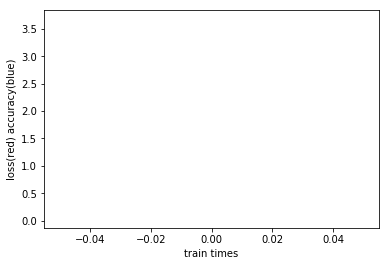

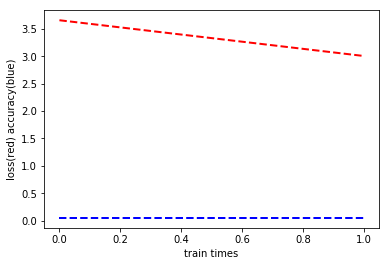

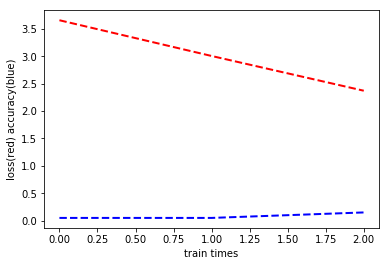

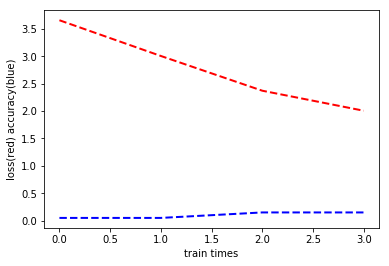

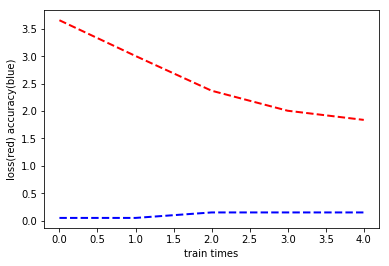

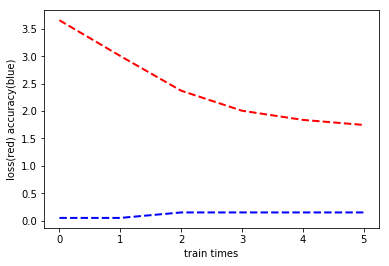

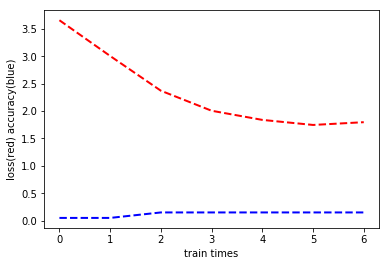

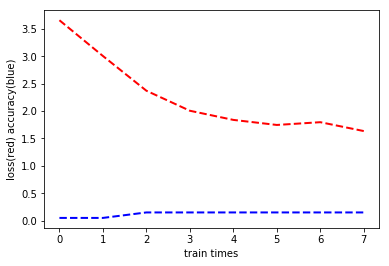

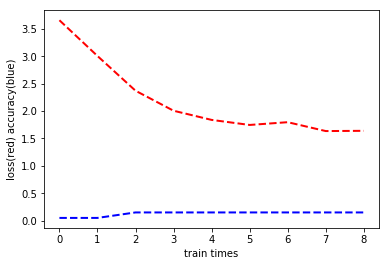

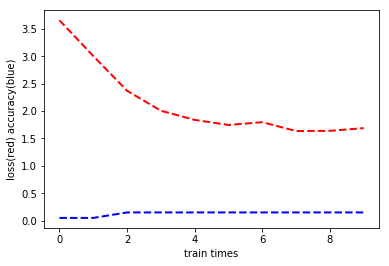

In [17]:
############################### train test Batch Normalization ###############################
# 运行这个cell测试batch normalization（注意将最下方train函数的注释去掉）
# 输出loss+accuracy和训练次数的可视化结果
# 这个模型将在正态分布初始化后开始训练

import random
import matplotlib.pyplot as plt # 绘图

MODEL_PATH = 'model_test\\model.dat'

def num2oneHot(nums,len_):
    """
    nums:列表
    len_:one-hot向量长度
    return one-hot 向量[0:len-1]
    """
    result = []
    for i in range(len(nums)):
        result.append([])
        num = int(nums[i])
        for j in range(num):
            result[i].append(0)
        result[i].append(1)
        for j in range(len_-num-1):
            result[i].append(0)
    return result

def train():
    train_images = load_train_images()
    train_labels = load_train_labels()
    test_images = load_test_images()
    test_labels = load_test_labels()
    
    batch_size = 20
    learning_rate = 0.0005
    train_num = 1 # 训练次数
    it_num = 10 # 每次训练迭代次数
    init_type = 'RANDOM'

    net = ConvNet()
    if not net.load(MODEL_PATH):      
        net.addConvLayout([3,3,1,4],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([3,3,4,8],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([5,5,8,16],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([5,5,16,32],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([16,16,32,64],bias = True,padding='VAILD',st_func='SIGMOID',init_type=init_type)
        net.addConvLayout([1,1,64,10],bias = True,padding='VAILD',st_func='SIGMOID',init_type=init_type)

    bn_net = BNNet()
    main_net = MainNet(bn_net)
    main_net.addNet(net)

    for j in range(train_num):
        # test_data -> accuracy
        index_test = random.randint(1,len(test_images)-batch_size-1)
        test_data = test_images[index_test:index_test+batch_size]
        test_data = numpy.reshape(test_data,[batch_size,28,28,1])
        test_label = test_labels[index_test:index_test+batch_size]
        # -----------------------------------plt---------------------------------------
        x_data = []
        y_data = []
        t_data = []
        # -----------------------------------------------------------------------------
        for i in range(it_num):
            index = random.randint(1,len(train_images)-batch_size-1)
            # index = 0
            data = train_images[index:index+batch_size]
            data = numpy.reshape(data,[batch_size,28,28,1])
            label = train_labels[index:index+batch_size]
            # 改为one_hot向量
            label = num2oneHot(label,10)
            label = numpy.reshape(label,[batch_size,1,1,10])

            # accuracy
            main_net.addData(test_data)
            result = net.count()[:,0,0,:]
            correct_num = 0
            error_num = 0
            for j in range(batch_size):
                m = 0
                for u in range(len(result[j])):
                    if result[j][u] > result[j][m]:
                        m = u
                if int(test_label[j]) == m:
                    correct_num += 1
                else:
                    error_num += 1
            # -----------------------------------plt---------------------------------------
            x_data.append(i)
            t_data.append(correct_num/batch_size)
            plt.plot(x_data,t_data,color='blue',linewidth=2.0,linestyle='--')
            # print('accuracy:'+str(correct_num/batch_size))
            # loss
            main_net.addData(data)
            loss = sum(sum(sum(sum(abs(net.count()-label)))))/batch_size
            # print(loss)
            # -----------------------------------plt---------------------------------------
            y_data.append(loss)
            plt.plot(x_data,y_data,color='red',linewidth=2.0,linestyle='--')
            plt.xlabel('train times')
            plt.ylabel('loss(red) accuracy(blue)')
            plt.pause(0.1)
            # -----------------------------------------------------------------------------
            net.regress(learning_rate,label,regress_type='SGD',loss_type = 'CE')  # 进行梯度下降
            learning_rate = 0.8*learning_rate
        
    # loss = sum(sum(sum(sum(abs(net.count()-label)))))/batch_size
    # print(loss)

    # net.save(MODEL_PATH)

# 训练及测试请去除下列函数的注释标号
train()

In [40]:
############################### NESTEROV ###################################
class Nesterov:
    def __init__(self):
        self.v = [] # 初始速度 为0
        self.alpha = 0.5 # 动量参数 v<-alpha*v+Loss
        self.layout_index = 0 # 从后到前的layout
        # filter <- filter - v
        # filter_loss = v

    def regress(self,loss,data,conv_filter,conv_bias,strides,padding,learning_rate):
        """
        进行梯度下降
        loss:经过激活函数传递上来的损失值
        data:上一层参数
        conv_filter:算子
        conv_bias:偏置项
        st_func(conv2d(data,filter)) = now_layout
        strides:[dy,dx]步长
        learning_rate:学习率
        返回filter_loss,bias_loss
        """
        fh,fw,channel_in,channel_out = conv_filter.shape # 当前filter
        [batch_size,m,n,channel_out] = loss.shape

        if len(self.v) <= self.layout_index:
            # 添加初始动量
            self.v.append(numpy.zeros([fh,fw,channel_in,channel_out]))
        conv_filter_new = conv_filter - self.alpha * self.v[self.layout_index]
        loss_new = deconv2d(loss,conv_filter_new,strides,padding) # 针对data的loss
        data_new = data - loss_new
        # [fh,fw,channel_in] .* [fh,fw,channel_in,channel_out] = [1,1,channel_out] 
        # [fh,fw,channel_in,cho] = [fh,fw,channel_in] * [1,1,cho] .* learning_rate / filter_size
        filter_loss = numpy.zeros(conv_filter.shape)
        bias_loss = numpy.zeros(conv_bias.shape)
        [lb,lh,lw,lc] = loss.shape
        K = learning_rate/batch_size
        for b in range(batch_size):
            for x in range(lh):
                x = x*strides[0]
                for y in range(lw):
                    y = y*strides[1]
                    for ch in range(channel_out):
                        filter_loss[:,:,:,ch] = filter_loss[:,:,:,ch] + loss[b,x,y,ch] * data_new[b,x:x+fh,y:y+fw,:]*K
                        bias_loss[ch] = loss[b,x,y,ch]*K
        self.v[self.layout_index] = self.v[self.layout_index]*self.alpha+filter_loss               
        filter_loss = self.v[self.layout_index]
        self.layout_index = self.layout_index + 1 # 下一层
        return filter_loss,bias_loss,loss_new

    def __str__(self):
        return 'NESTEROV'

    def reinit(self):
        """
        每次优化时初始化
        """
        self.layout_index = 0

魔数:2051, 图片数量: 60000张, 图片大小: 28*28
16
>784B 16 784
已解析 10000张
7839232
已解析 20000张
15679232
已解析 30000张
23519232
已解析 40000张
31359232
已解析 50000张
39199232
已解析 60000张
47039232
魔数:2049, 图片数量: 60000张
已解析 10000张
已解析 20000张
已解析 30000张
已解析 40000张
已解析 50000张
已解析 60000张


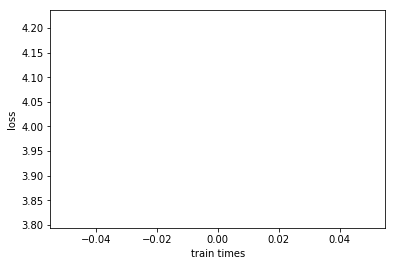

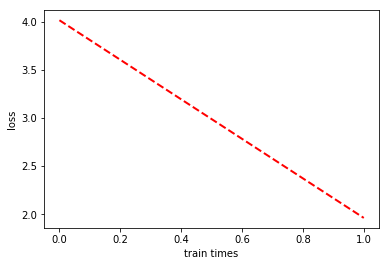

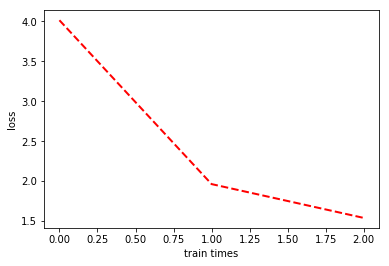

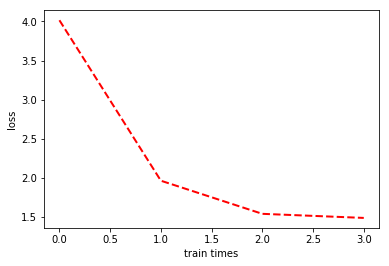

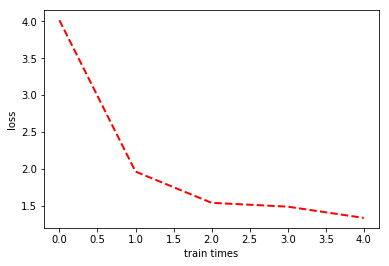

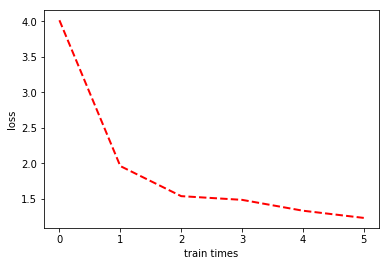

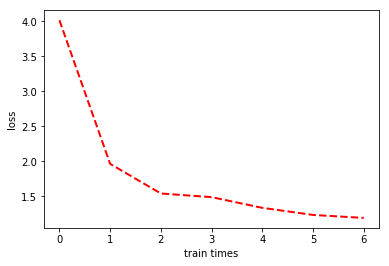

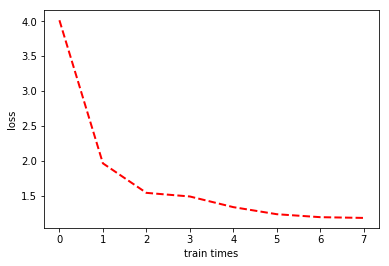

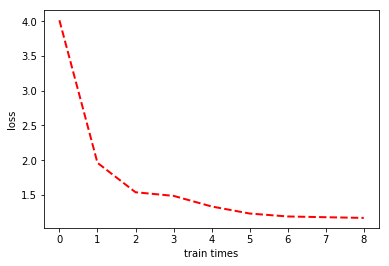

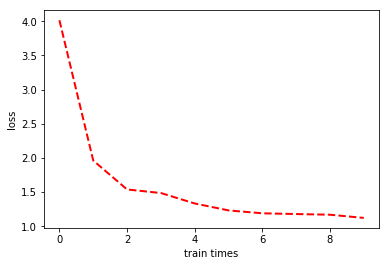

In [31]:
############################### train test Nesterov ###############################
# 运行这个cell测试nesterov（注意将最下方train函数的注释去掉）
# 输出loss和训练次数的可视化结果
# 这个模型将在正态分布初始化后开始训练

import random
import matplotlib.pyplot as plt # 绘图

MODEL_PATH_OLD = 'model_old\\3_3+3_3+5_5+connect\\model_200\\model.dat'
MODEL_PATH = 'model_test\\model.dat'

def num2oneHot(nums,len_):
    """
    nums:列表
    len_:one-hot向量长度
    return one-hot 向量[0:len-1]
    """
    result = []
    for i in range(len(nums)):
        result.append([])
        num = int(nums[i])
        for j in range(num):
            result[i].append(0)
        result[i].append(1)
        for j in range(len_-num-1):
            result[i].append(0)
    return result

def train():
    train_images = load_train_images()
    train_labels = load_train_labels()
    
    batch_size = 30
    learning_rate = 0.0001
    train_num = 1 # 训练次数
    it_num = 10 # 每次训练迭代次数
    init_type = 'RANDOM'

    net = ConvNet()
    if not net.load(MODEL_PATH):      
        net.addConvLayout([3,3,1,4],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([3,3,4,8],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([5,5,8,16],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([5,5,16,32],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([16,16,32,64],bias = True,padding='VAILD',st_func='SIGMOID',init_type=init_type)
        net.addConvLayout([1,1,64,10],bias = True,padding='VAILD',st_func='SIGMOID',init_type=init_type)

    for j in range(train_num):
        index = random.randint(1,len(train_images)-batch_size-1)
        # index = 0
        data = train_images[index:index+batch_size]
        data = numpy.reshape(data,[batch_size,28,28,1])
        label = train_labels[index:index+batch_size]
        # 改为one_hot向量
        label = num2oneHot(label,10)
        label = numpy.reshape(label,[batch_size,1,1,10])
        net.addData(data)
        # -----------------------------------plt---------------------------------------
        x_data = []
        y_data = []
        # -----------------------------------------------------------------------------
        for i in range(it_num):
            loss = sum(sum(sum(sum(abs(net.count()-label)))))/batch_size
            # -----------------------------------plt---------------------------------------
            x_data.append(i)
            y_data.append(loss)
            plt.plot(x_data,y_data,color='red',linewidth=2.0,linestyle='--')
            plt.xlabel('train times')
            plt.ylabel('loss')
            plt.pause(0.1)
            # -----------------------------------------------------------------------------
            # print(net.conv_filter[0][:,:,0,0])
            # print(loss)
            net.regress(learning_rate,label,regress_type='NESTEROV',loss_type = 'CE')  # 进行梯度下降
        # print('saving...')
        # net.save(MODEL_PATH)
        # print('finish!') 
        learning_rate = 0.995*learning_rate
        
    loss = sum(sum(sum(sum(abs(net.count()-label)))))/batch_size
    # print(loss)

    # net.save(MODEL_PATH)

# 训练或简要测试请去除下列函数的注释标号
# train()

In [11]:
############################################## RMS PROP ######################################
class RMSProp:
    def __init__(self):
        self.r = [] # 累积平方梯度
        self.ro = 0.5 # 衰减速率
        self.min_error = 0.000001 # 小常数
        self.layout_index = 0 # 从后到前的layout
        # filter <- filter - v
        # filter_loss = v

    def regress(self,loss,data,conv_filter,conv_bias,strides,padding,learning_rate):
        """
        进行梯度下降
        loss:经过激活函数传递上来的损失值
        data:上一层参数
        conv_filter:算子
        conv_bias:偏置项
        st_func(conv2d(data,filter)) = now_layout
        strides:[dy,dx]步长
        learning_rate:学习率
        返回filter_loss,bias_loss
        """
        fh,fw,channel_in,channel_out = conv_filter.shape # 当前filter
        [batch_size,m,n,channel_out] = loss.shape

        if len(self.r) <= self.layout_index:
            # 添加初始累积平方梯度
            self.r.append(numpy.zeros([fh,fw,channel_in,channel_out]))
        # [fh,fw,channel_in] .* [fh,fw,channel_in,channel_out] = [1,1,channel_out] 
        # [fh,fw,channel_in,cho] = [fh,fw,channel_in] * [1,1,cho] .* learning_rate / filter_size
        filter_loss = numpy.zeros(conv_filter.shape)
        bias_loss = numpy.zeros(conv_bias.shape)
        [lb,lh,lw,lc] = loss.shape
        K = learning_rate/batch_size
        for b in range(batch_size):
            for x in range(lh):
                x = x*strides[0]
                for y in range(lw):
                    y = y*strides[1]
                    for ch in range(channel_out):
                        filter_loss[:,:,:,ch] = filter_loss[:,:,:,ch] + loss[b,x,y,ch] * data[b,x:x+fh,y:y+fw,:]*K
                        bias_loss[ch] = loss[b,x,y,ch]*K
        # 更新累积梯度
        self.r[self.layout_index] = self.r[self.layout_index] * self.ro + (1-self.ro)*filter_loss*filter_loss;    
        loss = deconv2d(loss,conv_filter,strides,padding) # 更新loss           
        filter_loss = filter_loss/numpy.sqrt(self.r[self.layout_index]+self.min_error)
        self.layout_index = self.layout_index + 1 # 下一层
        return filter_loss,bias_loss,loss

    def __str__(self):
        return 'RMSPROP'

    def reinit(self):
        """
        每次优化时初始化
        """
        self.layout_index = 0

魔数:2051, 图片数量: 60000张, 图片大小: 28*28
16
>784B 16 784
已解析 10000张
7839232
已解析 20000张
15679232
已解析 30000张
23519232
已解析 40000张
31359232
已解析 50000张
39199232
已解析 60000张
47039232
魔数:2049, 图片数量: 60000张
已解析 10000张
已解析 20000张
已解析 30000张
已解析 40000张
已解析 50000张
已解析 60000张


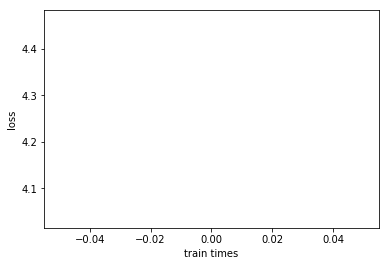

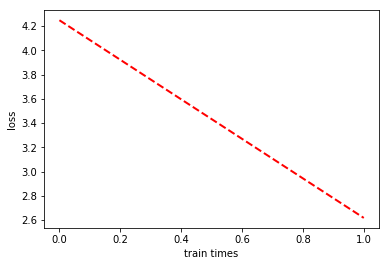

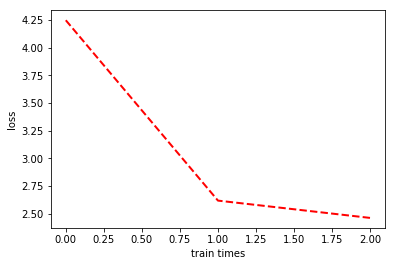

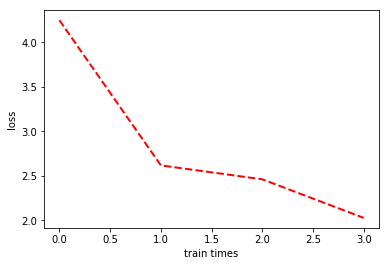

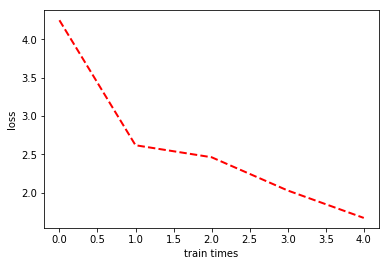

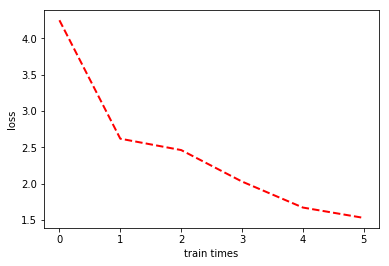

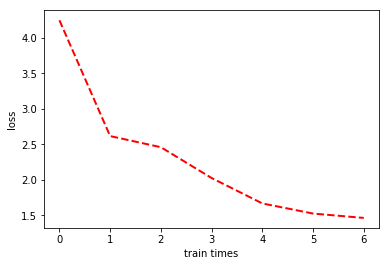

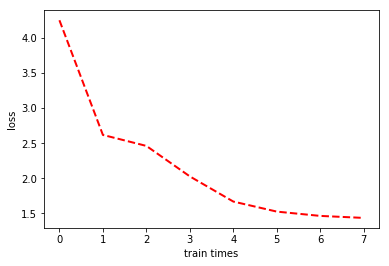

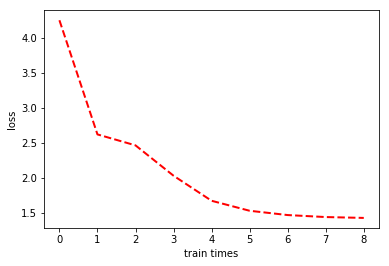

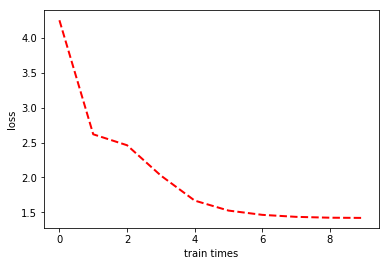

In [16]:
############################### train test RMSProp ###############################
# 运行这个cell测试RMSProp（注意将最下方train函数的注释去掉）
# 输出loss和训练次数的可视化结果
# 这个模型将在正态分布初始化后开始训练

import random
import matplotlib.pyplot as plt # 绘图

MODEL_PATH_OLD = 'model_old\\3_3+3_3+5_5+connect\\model_200\\model.dat'
MODEL_PATH = 'model_test\\model.dat'

def num2oneHot(nums,len_):
    """
    nums:列表
    len_:one-hot向量长度
    return one-hot 向量[0:len-1]
    """
    result = []
    for i in range(len(nums)):
        result.append([])
        num = int(nums[i])
        for j in range(num):
            result[i].append(0)
        result[i].append(1)
        for j in range(len_-num-1):
            result[i].append(0)
    return result

def train():
    train_images = load_train_images()
    train_labels = load_train_labels()
    
    batch_size = 30
    learning_rate = 0.0001
    train_num = 1 # 训练次数
    it_num = 10 # 每次训练迭代次数
    init_type = 'RANDOM'

    net = ConvNet()
    if not net.load(MODEL_PATH):      
        net.addConvLayout([3,3,1,4],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([3,3,4,8],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([5,5,8,16],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([5,5,16,32],bias = True,padding='VAILD',init_type=init_type,st_func='LEAKY_RELU_0.01')
        net.addConvLayout([16,16,32,64],bias = True,padding='VAILD',st_func='SIGMOID',init_type=init_type)
        net.addConvLayout([1,1,64,10],bias = True,padding='VAILD',st_func='SIGMOID',init_type=init_type)

    for j in range(train_num):
        index = random.randint(1,len(train_images)-batch_size-1)
        # index = 0
        data = train_images[index:index+batch_size]
        data = numpy.reshape(data,[batch_size,28,28,1])
        label = train_labels[index:index+batch_size]
        # 改为one_hot向量
        label = num2oneHot(label,10)
        label = numpy.reshape(label,[batch_size,1,1,10])
        net.addData(data)
        # -----------------------------------plt---------------------------------------
        x_data = []
        y_data = []
        # -----------------------------------------------------------------------------
        for i in range(it_num):
            loss = sum(sum(sum(sum(abs(net.count()-label)))))/batch_size
            # -----------------------------------plt---------------------------------------
            x_data.append(i)
            y_data.append(loss)
            plt.plot(x_data,y_data,color='red',linewidth=2.0,linestyle='--')
            plt.xlabel('train times')
            plt.ylabel('loss')
            plt.pause(0.1)
            # -----------------------------------------------------------------------------
            # print(net.conv_filter[0][:,:,0,0])
            # print(loss)
            net.regress(learning_rate,label,regress_type='RMSPROP',loss_type = 'CE')  # 进行梯度下降
        # print('saving...')
        # net.save(MODEL_PATH)
        # print('finish!') 
        learning_rate = 0.995*learning_rate
        
    loss = sum(sum(sum(sum(abs(net.count()-label)))))/batch_size
    # print(loss)

    # net.save(MODEL_PATH)

# 训练或简要测试请去除下列函数的注释标号
train()